<!-- Copyright (c) 2021-2022, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted (subject to the limitations in the disclaimer
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice,
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its
contributors may be used to endorse or promote products derived from this
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# Compressai Models Comparison Demo

In [ ]:
!pip install compressai

In [ ]:
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
from pytorch_msssim import ms_ssim

In [ ]:
from compressai.zoo import (bmshj2018_factorized, bmshj2018_hyperprior, mbt2018_mean, mbt2018, cheng2020_anchor)

In [ ]:
from ipywidgets import interact, widgets

## Global settings

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = 'mse'  # only pre-trained model for mse are available for now
quality = 6  # lower quality -> lower bit-rate (use lower quality to clearly see visual differences in the notebook)

## Load some pretrained models

In [ ]:
networks = {
    # 'bmshj2018-factorized': bmshj2018_factorized(quality=quality, pretrained=True).eval().to(device),
    # 'bmshj2018-hyperprior': bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device),
    # 'mbt2018-mean': mbt2018_mean(quality=quality, pretrained=True).eval().to(device),
    # 'mbt2018': mbt2018(quality=quality, pretrained=True).eval().to(device),
    'cheng2020-anchor': cheng2020_anchor(quality=quality, pretrained=True).eval().to(device),
}
# networks = {
#     'cheng2020-anchor': cheng2020_anchor(quality=quality, pretrained=True).eval().to(device),
# }

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020-anchor-6-4c052b1a.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020-anchor-6-4c052b1a.pth.tar
100%|██████████| 109M/109M [00:06<00:00, 16.5MB/s]


## Inference

### Load input data

In [ ]:
def cv2png(input_path, output_path):
    try:
        # 打開JPEG圖片
        with Image.open(input_path) as img:
            # 將圖片保存為PNG格式
            img.save(output_path, "PNG")
            print(f"轉換成功：{output_path}")
    except Exception as e:
        print(f"轉換失敗：{str(e)}")
# cv2png('./dataset/船1.jpg', './dataset/船1.png');

In [ ]:
# img = Image.oimg = Image.open('./dataset/default.png').convert('L').convert('RGB')
# print(img.size)
path = './formal/data1.jpg'
ori_img = Image.oimg = Image.open('./data8.jpg').convert('L').convert('RGB')
# img = Image.oimg = Image.open(path).convert('L').convert('RGB')
# img = ori_img.crop((500, 500, 1012, 1012))
ori_img = ori_img.crop((10, 10, 330, 330))
######### set other channels to be 0
arr = np.asarray(ori_img)
arr = arr.copy()
for i in arr:
  for j in i:
    j[0] = 0
img = Image.fromarray(arr)
#########
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

<ipython-input-101-0462c0569174>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


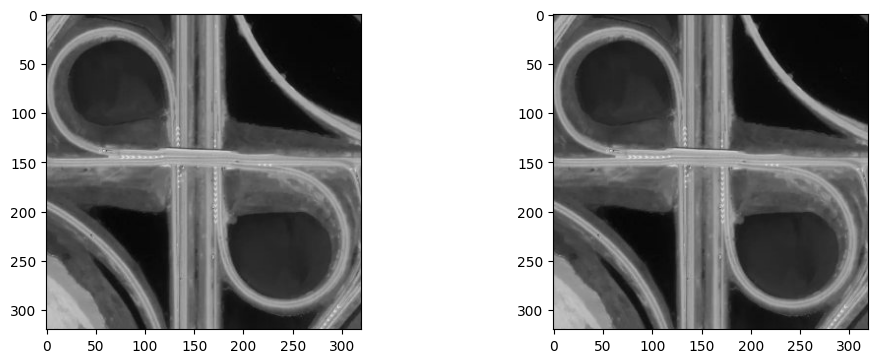

In [ ]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.subplot(222)
plt.imshow(ori_img, cmap='gray')
plt.show()

### Run the networks

In [ ]:
outputs = {}
with torch.no_grad():
    for name, net in networks.items():
        rv = net(x)
        rv['x_hat'].clamp_(0, 1)
        outputs[name] = rv

### Visualize the reconstructions

In [ ]:
reconstructions = {name: transforms.ToPILImage()(out['x_hat'].squeeze())
                  for name, out in outputs.items()}

In [ ]:
diffs = [torch.mean((out['x_hat'] - x).abs(), axis=1).squeeze()
        for out in outputs.values()]

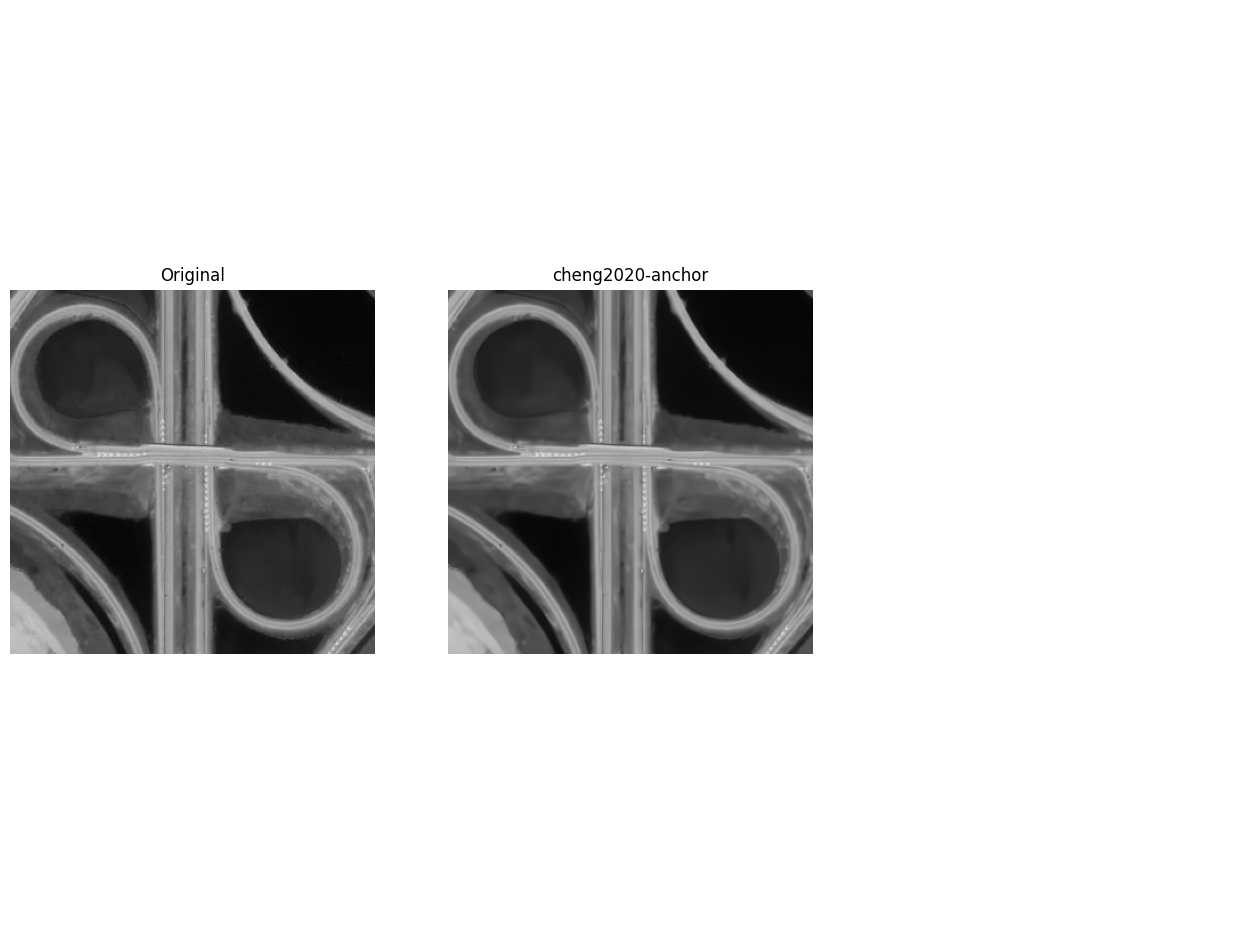

In [ ]:
%matplotlib inline
fix, axes = plt.subplots((len(reconstructions) + 2)// 3, 3, figsize=(16, 12))
for ax in axes.ravel():
    ax.axis('off')

# axes.ravel()[0].imshow(img.crop((468, 212, 768, 512)))
axes.ravel()[0].imshow(img)
axes.ravel()[0].title.set_text('Original')

for i, (name, rec) in enumerate(reconstructions.items()):
    # axes.ravel()[i + 1].imshow(rec.crop((468, 212, 768, 512))) # cropped for easy comparison
    ######### convert to grayscale
    arr = np.asarray(rec)
    arr = arr.copy()
    for row in arr:
      for column in row:
        column[0] = column[1]
    rec = Image.fromarray(arr)
    #########
    axes.ravel()[i + 1].imshow(rec)
    axes.ravel()[i + 1].title.set_text(name)
    # rec.save('data8_rec.png', 'PNG')

plt.show()
# print('ori=', img.size,' rec=', rec.size)

## Metric

In [ ]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [ ]:
metrics = {}
for name, out in outputs.items():
    metrics[name] = {
        'psnr': compute_psnr(x, out["x_hat"]),
        'ms-ssim': compute_msssim(x, out["x_hat"]),
        'bit-rate': compute_bpp(out),
    }

In [ ]:
header = f'{"Model":20s} | {"PSNR [dB]"} | {"MS-SSIM":<9s} | {"Bpp":<9s}|'
print('-'*len(header))
print(header)
print('-'*len(header))
for name, m in metrics.items():
    print(f'{name:20s}', end='')
    for v in m.values():
        print(f' | {v:9.3f}', end='')
    print('|')
print('-'*len(header))

---------------------------------------------------------
Model                | PSNR [dB] | MS-SSIM   | Bpp      |
---------------------------------------------------------
cheng2020-anchor     |    40.557 |     0.997 |     0.326|
---------------------------------------------------------


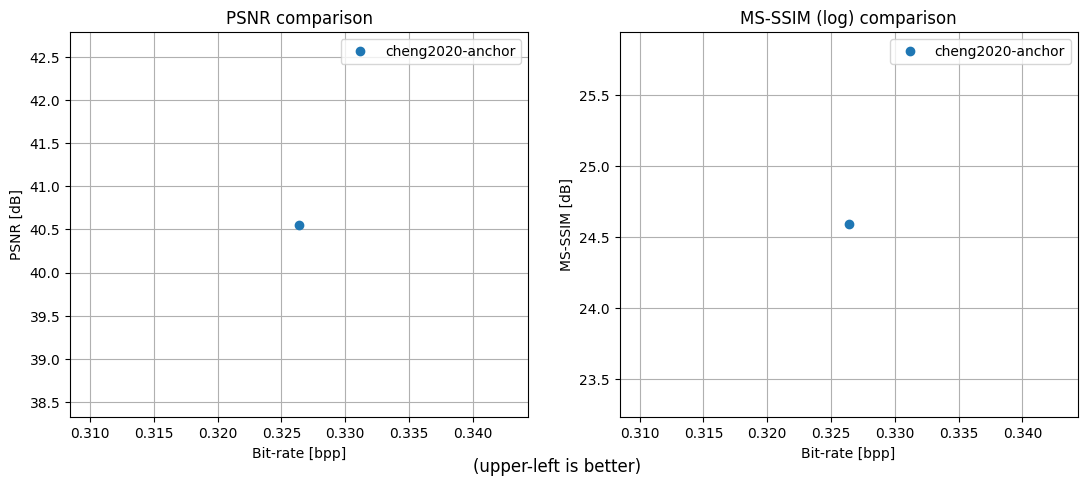

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
for name, m in metrics.items():
    axes[0].plot(m['bit-rate'], m['psnr'], 'o', label=name)
    axes[0].legend(loc='best')
    axes[0].grid()
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    axes[1].plot(m['bit-rate'], -10*np.log10(1-m['ms-ssim']), 'o', label=name)
    axes[1].legend(loc='best')
    axes[1].grid()
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()